# Customer Churn Prediction - End-to-End ML Pipeline
Author: Khubaib

##Table of Contents

1. Introduction and Problem Statement
2. Data Understanding and Preparation
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Modeling and Hyperparameter Tuning
6. Model Evaluation and Interpretation
7. Customer Segmentation Analysis
8. Business Recommendations

# 1. Introduction and Problem Statement

## 1.1 Background

Customer churn is a critical business problem across industries, particularly in subscription-based businesses like telecommunications, SaaS, and streaming services. When customers terminate their relationship with a company, it directly impacts revenue and growth metrics while increasing customer acquisition costs.

In the telecommunications industry specifically:
- Acquiring a new customer can cost 5-25 times more than retaining an existing one
- A 5% increase in customer retention can increase profits by 25-95%
- The probability of selling to an existing customer is 60-70%, while the probability of selling to a new prospect is only 5-20%

## 1.2 Problem Statement

Our goal is to build a machine learning system that can:
1. Accurately predict which customers are at high risk of churning
2. Identify the key factors contributing to churn
3. Enable targeted retention strategies by segmenting at-risk customers
4. Provide an interface for business stakeholders to utilize predictions

## 1.3 Project Approach

This notebook presents an end-to-end machine learning pipeline including:
- Comprehensive exploratory data analysis
- Feature engineering and preprocessing
- Model selection and hyperparameter tuning
- Model interpretation and explanation
- Customer segmentation analysis
- Business recommendations based on insights
- Deployment strategy


In [2]:

# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Feature preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model explanation
import shap
from sklearn.inspection import permutation_importance

# Customer segmentation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set visualization styles
plt.style.use('fivethirtyeight')
sns.set_palette('viridis')

# Settings for better readability of plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_context("talk")

# Display all columns
pd.set_option('display.max_columns', None)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 2. Data Understanding and Preparation
## 2.1 Load the Data

We'll be using the Telco Customer Churn dataset, which contains information about customers of a fictional telecommunications company, including whether they stayed with the company or churned.

In [3]:

# Load the dataset (adjust the path accordingly)
df = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv')

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()



Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.2 Data Overview and Information
 Let's examine the dataset structure and check for any missing values or inconsistencies.



In [4]:

# Dataset information
print("Dataset Information:")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nBasic Statistics:")
df.describe().T

# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

print("Missing Values Analysis:")
print(missing_data[missing_data['Missing Values'] > 0])



Dataset Information:
Number of Rows: 7043
Number of Columns: 21

Column Names and Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Basic Statistics:
Missing Values Analysis:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []



## 2.3 Data Cleaning and Preprocessing

Based on the initial inspection, let's clean and preprocess the data to prepare it for analysis and modeling.

In [5]:

# Create a copy of the dataset for cleaning
df_clean = df.copy()

# Handle CustomerID column
df_clean.drop('customerID', axis=1, inplace=True)

# Convert Total Charges to numeric (handle any spaces or empty strings)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

# Check for missing values in TotalCharges after conversion
print(f"Missing values in TotalCharges after conversion: {df_clean['TotalCharges'].isnull().sum()}")

# Fill missing TotalCharges with the corresponding MonthlyCharges * tenure
# This is a reasonable assumption for customers with very short tenure
mask = df_clean['TotalCharges'].isnull()
df_clean.loc[mask, 'TotalCharges'] = df_clean.loc[mask, 'MonthlyCharges'] * df_clean.loc[mask, 'tenure']

# Convert binary categorical variables to numeric
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})

# Convert the target variable to numeric
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})

# Handle tenure - create tenure groups
def create_tenure_groups(tenure):
    if tenure <= 12:
        return '0-12 months'
    elif tenure <= 24:
        return '13-24 months'
    elif tenure <= 36:
        return '25-36 months'
    elif tenure <= 48:
        return '37-48 months'
    elif tenure <= 60:
        return '49-60 months'
    else:
        return '60+ months'

df_clean['TenureGroup'] = df_clean['tenure'].apply(create_tenure_groups)

# Verify the cleaned data
print("\nCleaned Dataset Overview:")
df_clean.head()

# %%
# Check for any remaining missing values
print("Remaining missing values:")
print(df_clean.isnull().sum())


Missing values in TotalCharges after conversion: 11

Cleaned Dataset Overview:
Remaining missing values:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
TenureGroup         0
dtype: int64


# 3. Exploratory Data Analysis (EDA)

With our data cleaned and prepared, let's explore it to gain insights into customer behavior patterns and factors that might contribute to churn.

## 3.1 Target Variable Distribution

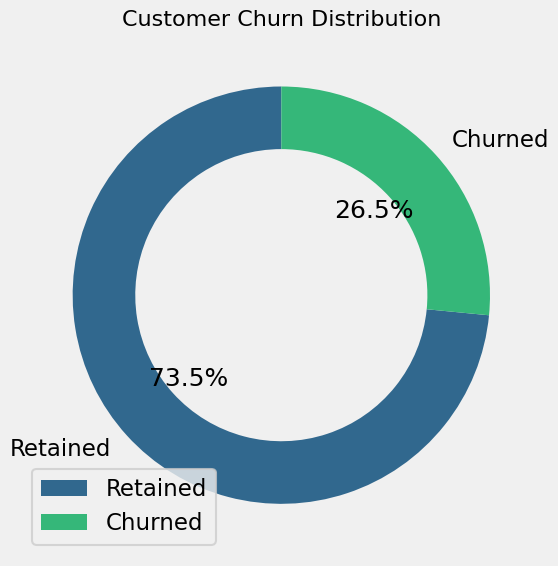

Churn Rate: 26.54%
Retention Rate: 73.46%


In [6]:

# Churn Distribution
plt.figure(figsize=(10, 6))
colors = sns.color_palette('viridis', 2)

churn_counts = df_clean['Churn'].value_counts()
churn_percent = (churn_counts / len(df_clean)) * 100

plt.pie(churn_percent, labels=['Retained', 'Churned'], autopct='%1.1f%%',
        startangle=90, colors=colors, wedgeprops=dict(width=0.3))
plt.title('Customer Churn Distribution', fontsize=16)
plt.legend(['Retained', 'Churned'])
plt.tight_layout()
plt.show()

print(f"Churn Rate: {churn_percent[1]:.2f}%")
print(f"Retention Rate: {churn_percent[0]:.2f}%")



## 3.2 Demographic Analysis

In [7]:

# Function to create churn rate bar plots by category
def plot_churn_rate_by_category(df, column, title):
    # Calculate churn rate by category
    churn_by_category = df.groupby(column)['Churn'].mean() * 100
    counts_by_category = df[column].value_counts()

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Churn Rate (%)': churn_by_category,
        'Count': counts_by_category
    }).reset_index()

    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot churn rate bars
    ax1.set_xlabel(column)
    ax1.set_ylabel('Churn Rate (%)', color='tab:blue')
    ax1.bar(plot_df[column], plot_df['Churn Rate (%)'], color='tab:blue', alpha=0.7)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create second y-axis for count
    ax2 = ax1.twinx()
    ax2.set_ylabel('Count', color='tab:red')
    ax2.plot(plot_df[column], plot_df['Count'], color='tab:red', marker='o', linestyle='-', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Add title and adjust layout
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print the exact values
    print(f"\nChurn Rate by {column}:")
    for idx, row in plot_df.iterrows():
        print(f"{row[column]}: {row['Churn Rate (%)']:.2f}% (Count: {row['Count']})")

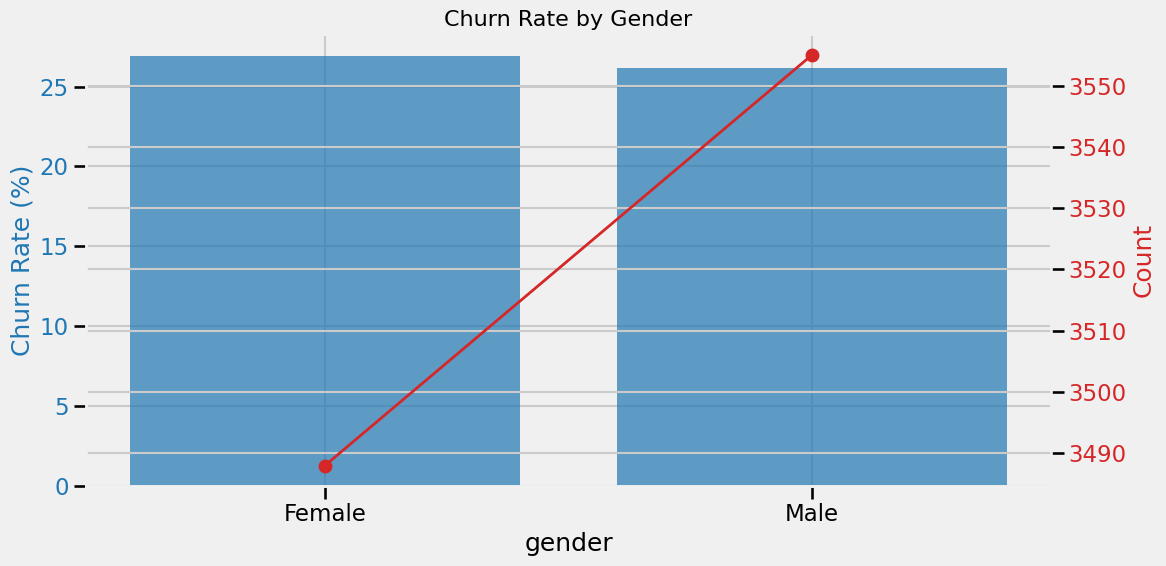


Churn Rate by gender:
Female: 26.92% (Count: 3488)
Male: 26.16% (Count: 3555)


In [8]:
# Plot demographic factors
plot_churn_rate_by_category(df_clean, 'gender', 'Churn Rate by Gender')

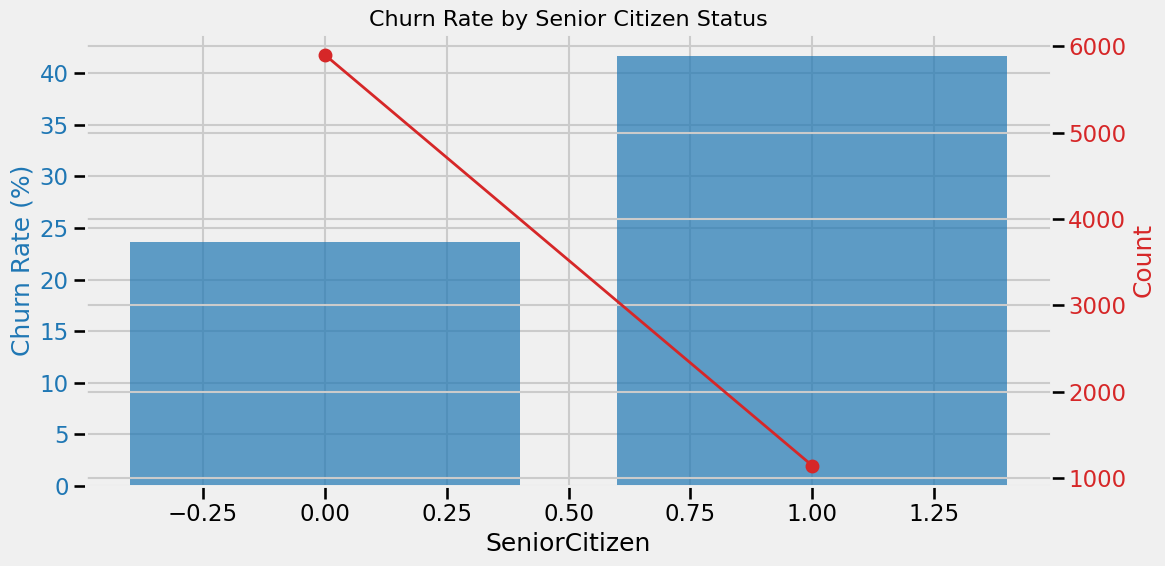


Churn Rate by SeniorCitizen:
0.0: 23.61% (Count: 5901.0)
1.0: 41.68% (Count: 1142.0)


In [9]:
plot_churn_rate_by_category(df_clean, 'SeniorCitizen', 'Churn Rate by Senior Citizen Status')

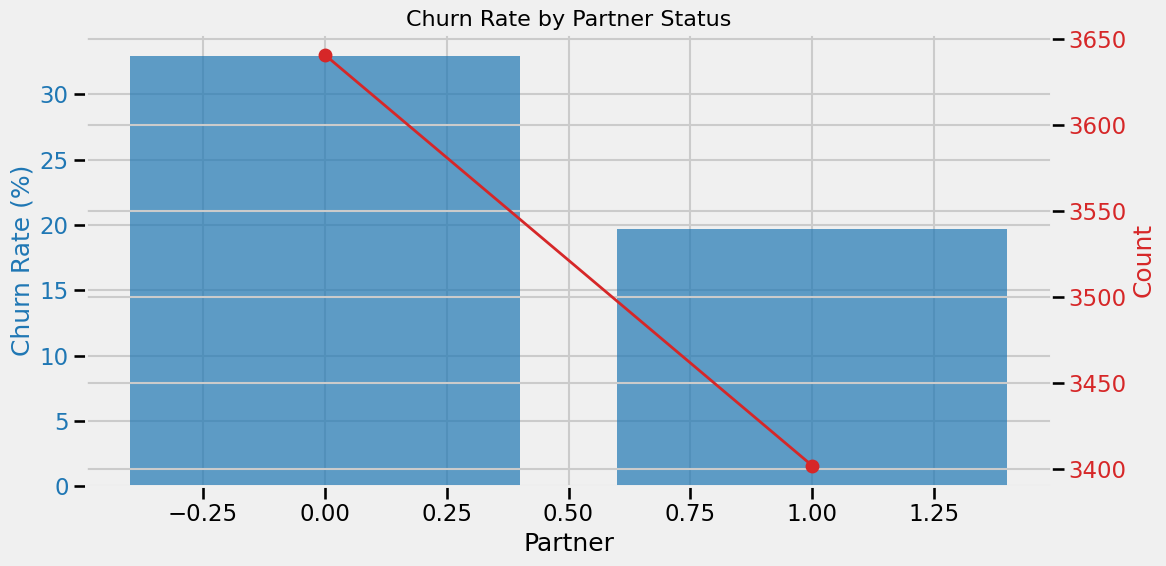


Churn Rate by Partner:
0.0: 32.96% (Count: 3641.0)
1.0: 19.66% (Count: 3402.0)


In [10]:
plot_churn_rate_by_category(df_clean, 'Partner', 'Churn Rate by Partner Status')

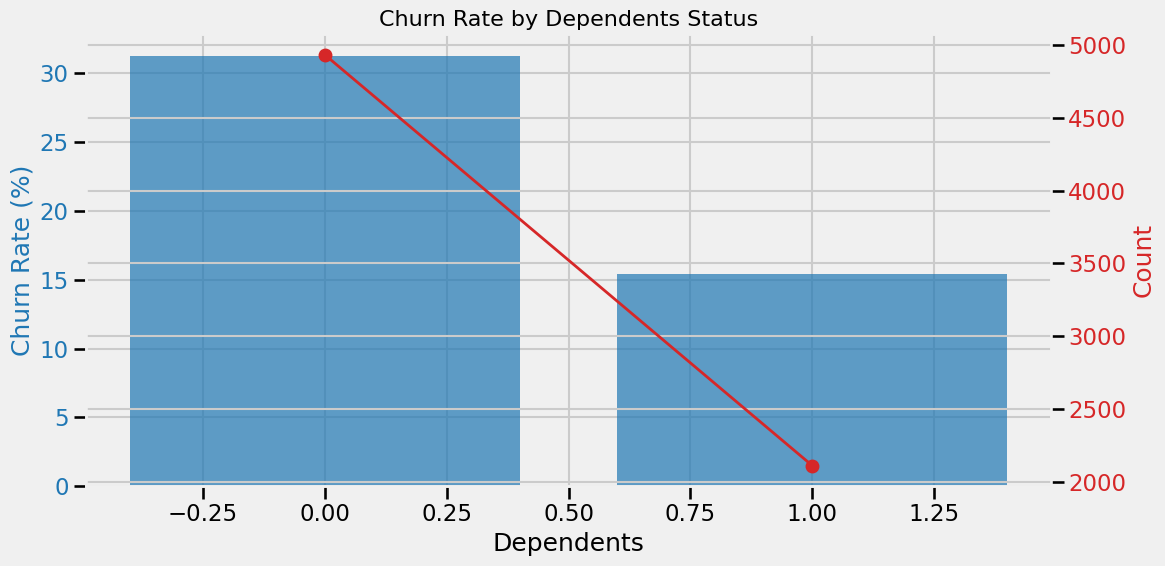


Churn Rate by Dependents:
0.0: 31.28% (Count: 4933.0)
1.0: 15.45% (Count: 2110.0)


In [11]:
plot_churn_rate_by_category(df_clean, 'Dependents', 'Churn Rate by Dependents Status')



## 3.3 Service Usage Analysis

<Figure size 1400x800 with 0 Axes>

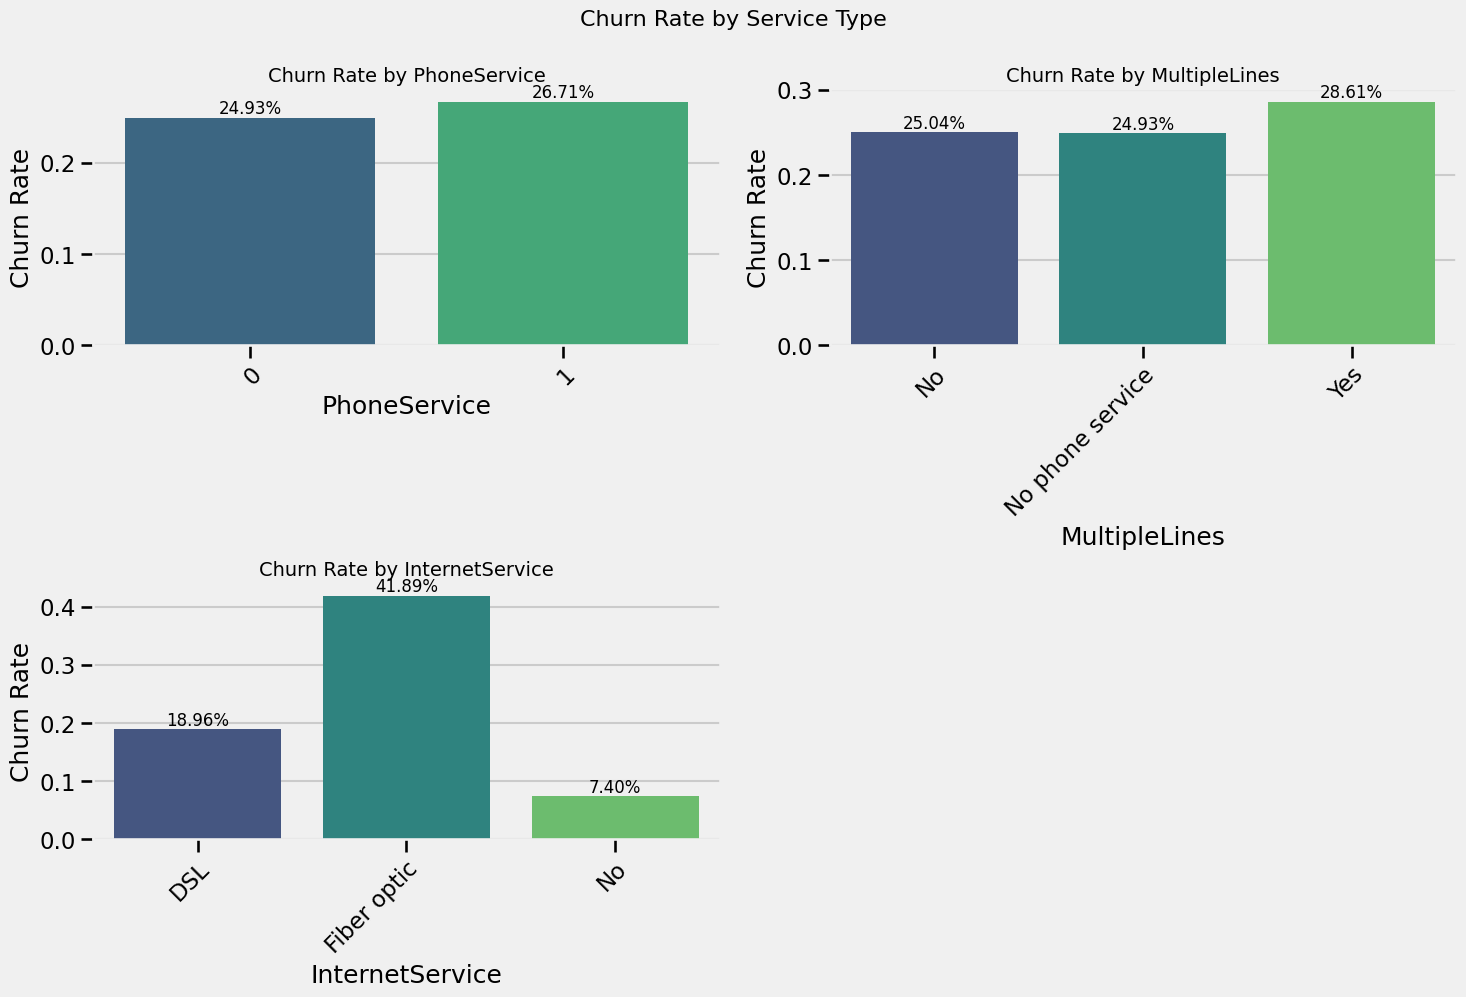

In [51]:

# Function to create grouped bar chart for service-related columns
def plot_churn_by_service(df, columns, title):
    plt.figure(figsize=(14, 8))

    # Calculate the number of subplot rows and columns
    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if i < len(axes):
            # Calculate churn rate by service
            service_churn = df.groupby(column)['Churn'].mean().reset_index()

            # Create the bar chart
            ax = sns.barplot(x=column, y='Churn', data=service_churn, palette='viridis', ax=axes[i])

            # Add labels
            ax.set_title(f'Churn Rate by {column}', fontsize=14)
            ax.set_ylabel('Churn Rate')

            # Improve x-axis label display - rotate and adjust as needed
            ax.set_xlabel(column)
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

            # Ensure enough space for rotated labels
            fig.tight_layout()

            # Add value labels on the bars
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2%}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom', fontsize=12)

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)  # Add more space at the bottom
    plt.show()

# Service-related columns
service_columns_1 = ['PhoneService', 'MultipleLines', 'InternetService']
# Plot service usage
plot_churn_by_service(df_clean, service_columns_1, 'Churn Rate by Service Type')

<Figure size 1400x800 with 0 Axes>

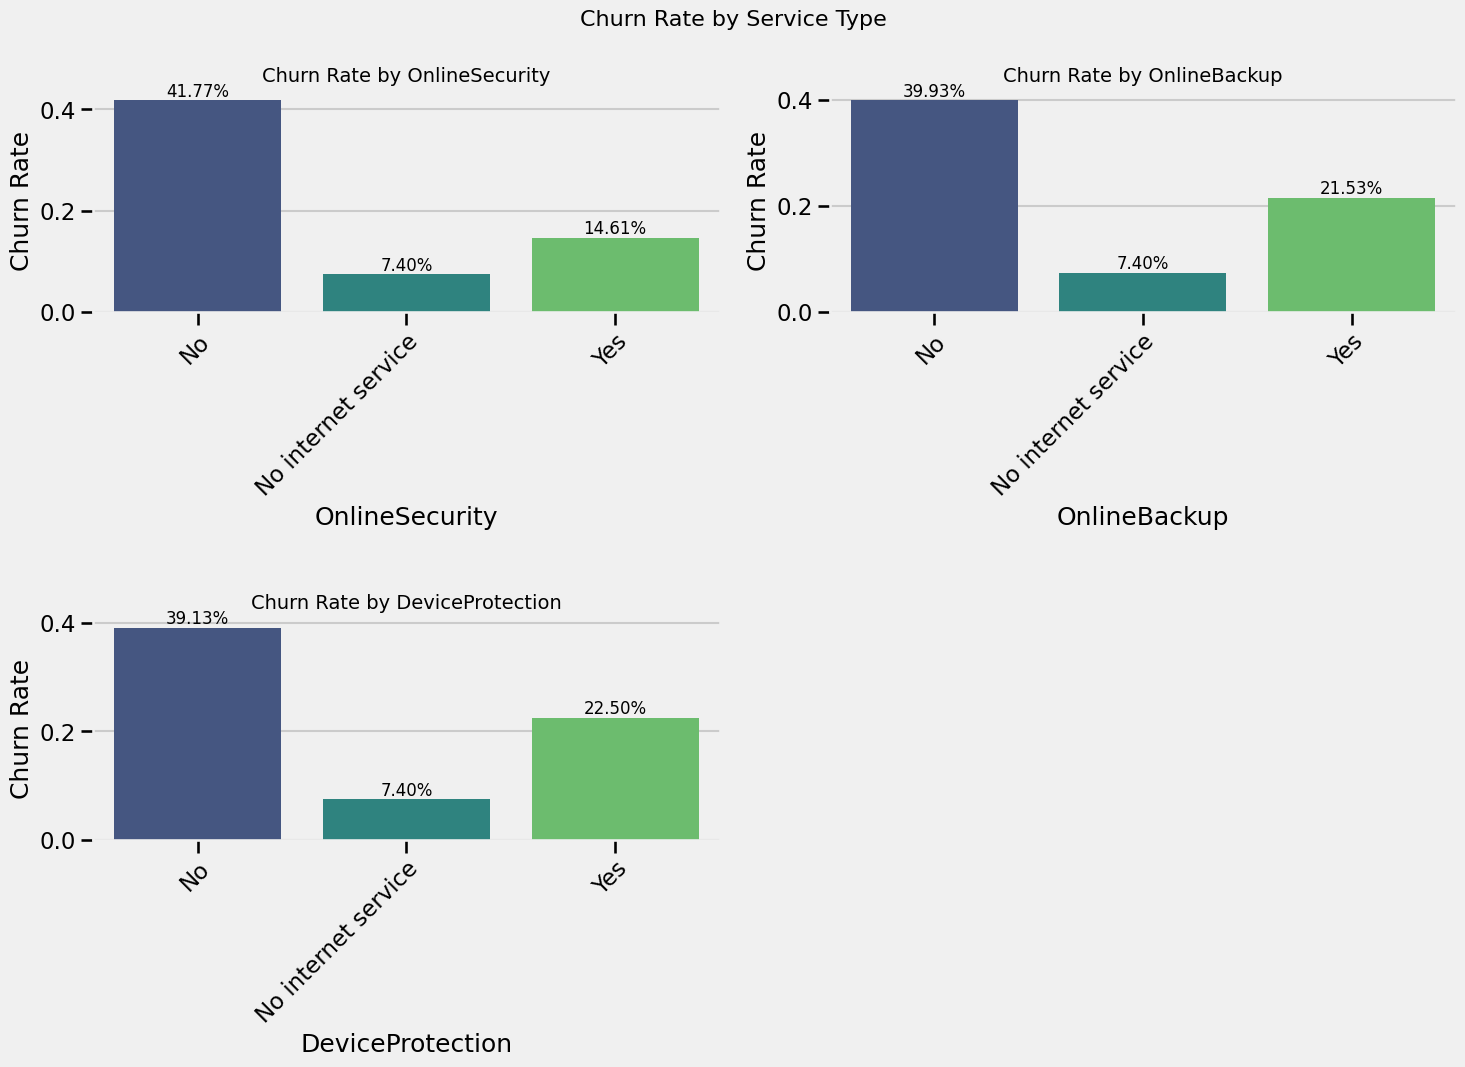

In [52]:
service_columns_2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']
# Plot service usage
plot_churn_by_service(df_clean, service_columns_2, 'Churn Rate by Service Type')


<Figure size 1400x800 with 0 Axes>

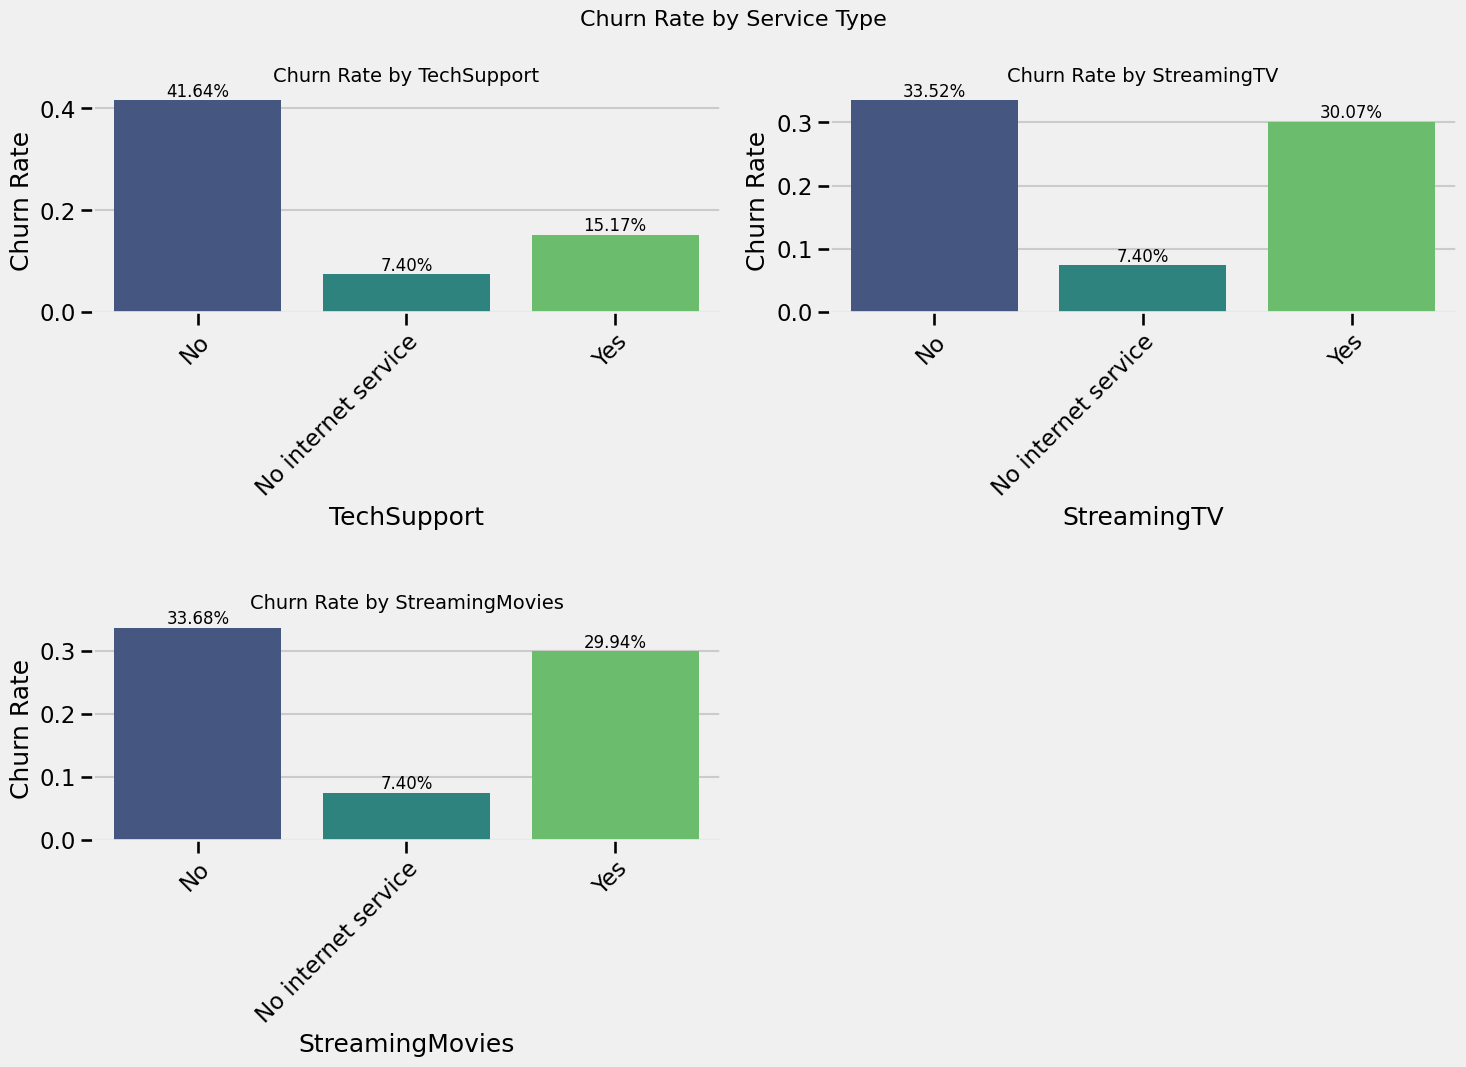

In [53]:
   service_columns_3 = ['TechSupport', 'StreamingTV', 'StreamingMovies']

   plot_churn_by_service(df_clean, service_columns_3, 'Churn Rate by Service Type')

 ## 3.4 Contract and Payment Analysis

<Figure size 1400x800 with 0 Axes>

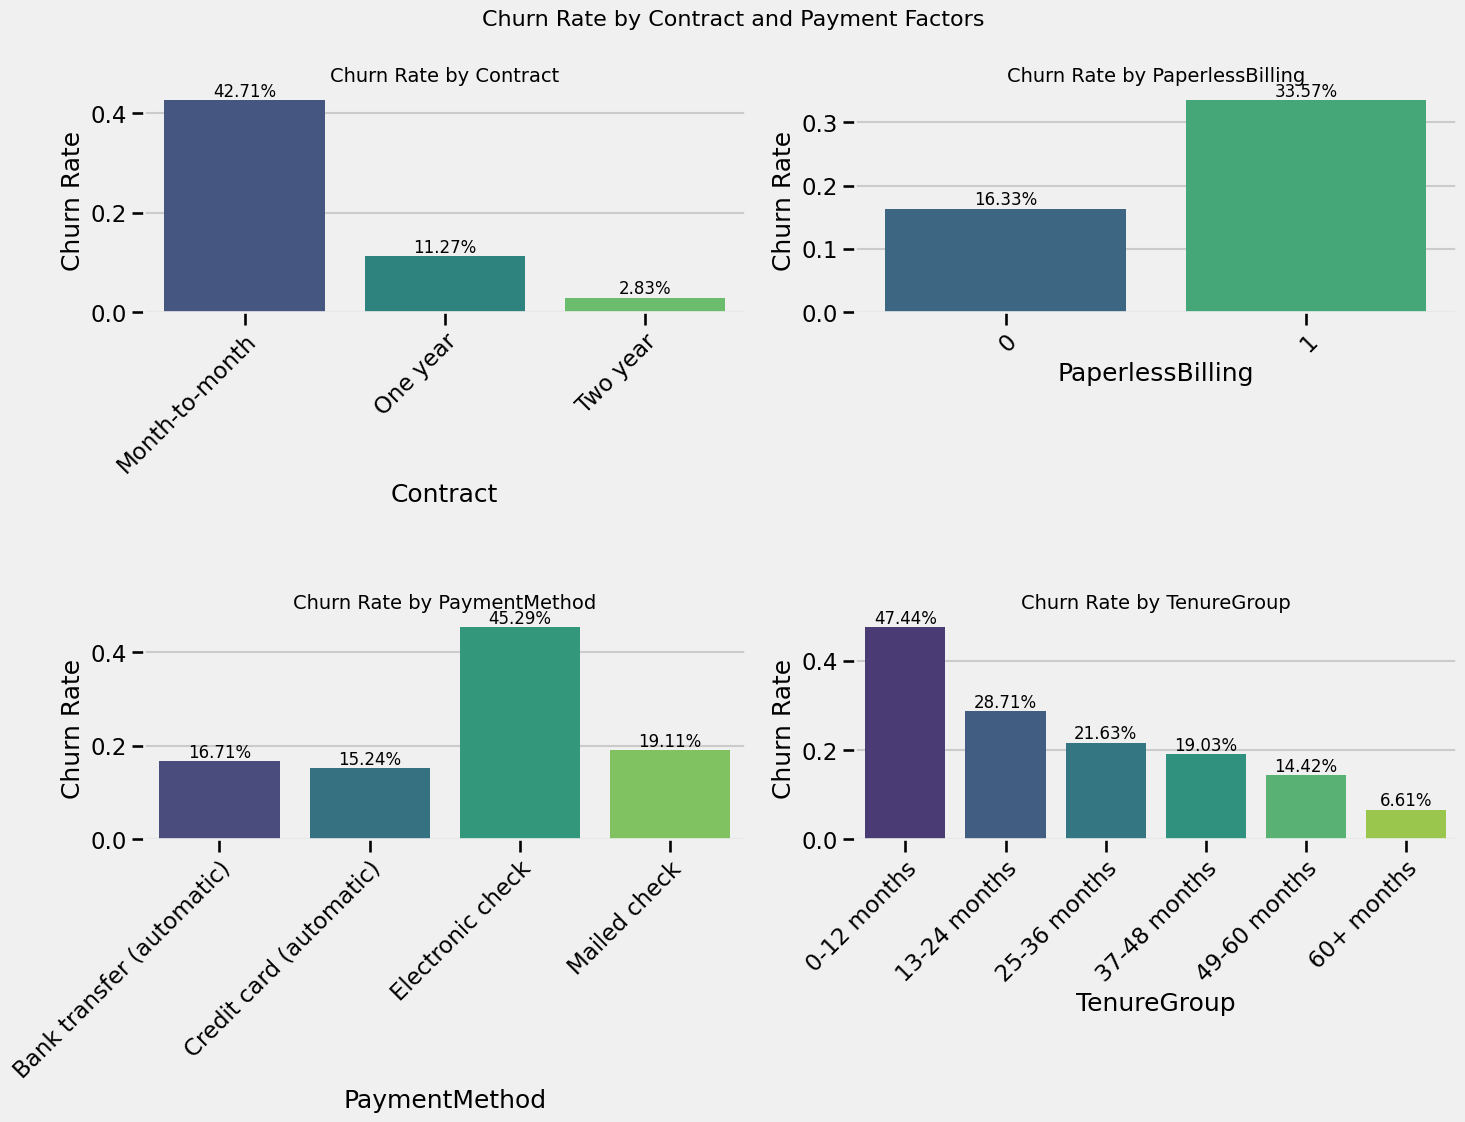

In [54]:
# Contract and payment analysis
contract_payment_cols = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']
plot_churn_by_service(df_clean, contract_payment_cols, 'Churn Rate by Contract and Payment Factors')


## 3.5 Numerical Feature Analysis

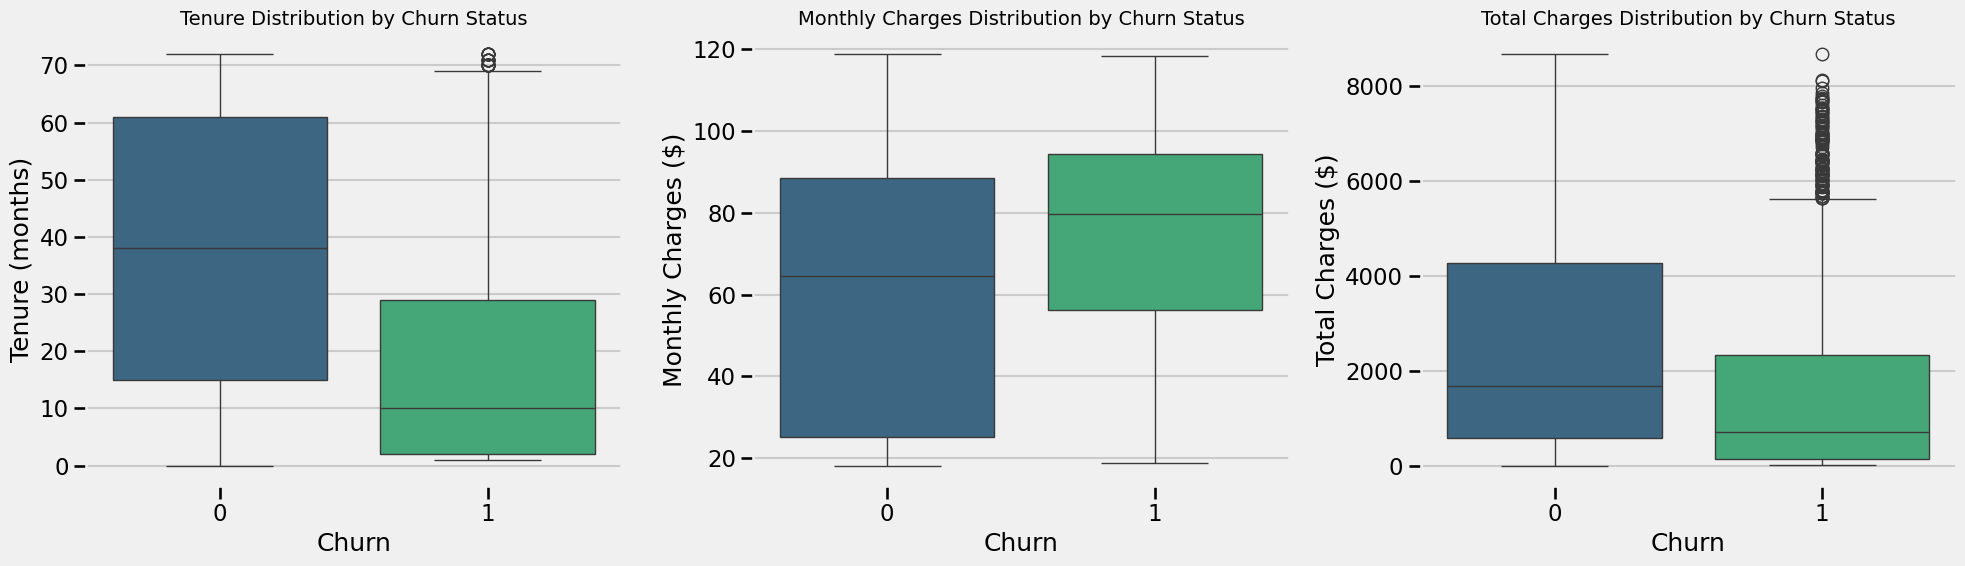

In [14]:

# Numerical features analysis
plt.figure(figsize=(20, 6))

# Tenure distribution by churn
plt.subplot(1, 3, 1)
sns.boxplot(x='Churn', y='tenure', data=df_clean, palette='viridis')
plt.title('Tenure Distribution by Churn Status', fontsize=14)
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')

# Monthly charges distribution by churn
plt.subplot(1, 3, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_clean, palette='viridis')
plt.title('Monthly Charges Distribution by Churn Status', fontsize=14)
plt.xlabel('Churn')
plt.ylabel('Monthly Charges ($)')

# Total charges distribution by churn
plt.subplot(1, 3, 3)
sns.boxplot(x='Churn', y='TotalCharges', data=df_clean, palette='viridis')
plt.title('Total Charges Distribution by Churn Status', fontsize=14)
plt.xlabel('Churn')
plt.ylabel('Total Charges ($)')

plt.tight_layout()
plt.show()

In [15]:


# Calculate and print statistics
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numerical_cols:
    print(f"\n{col} Statistics by Churn Status:")
    print(df_clean.groupby('Churn')[col].describe())


tenure Statistics by Churn Status:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1      1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0

MonthlyCharges Statistics by Churn Status:
        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
0      5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
1      1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35

TotalCharges Statistics by Churn Status:
        count         mean          std    min    25%       50%      75%  \
Churn                                                                      
0      5174.0  2549.911442  2329.954215   0.00  572.9  1679.525  4262.85   
1      1869.0  1531.796094  1890.822994  18.85  134.5   703.550  2331.30   

           max  
Churn   

## 3.6 Correlation Analysis

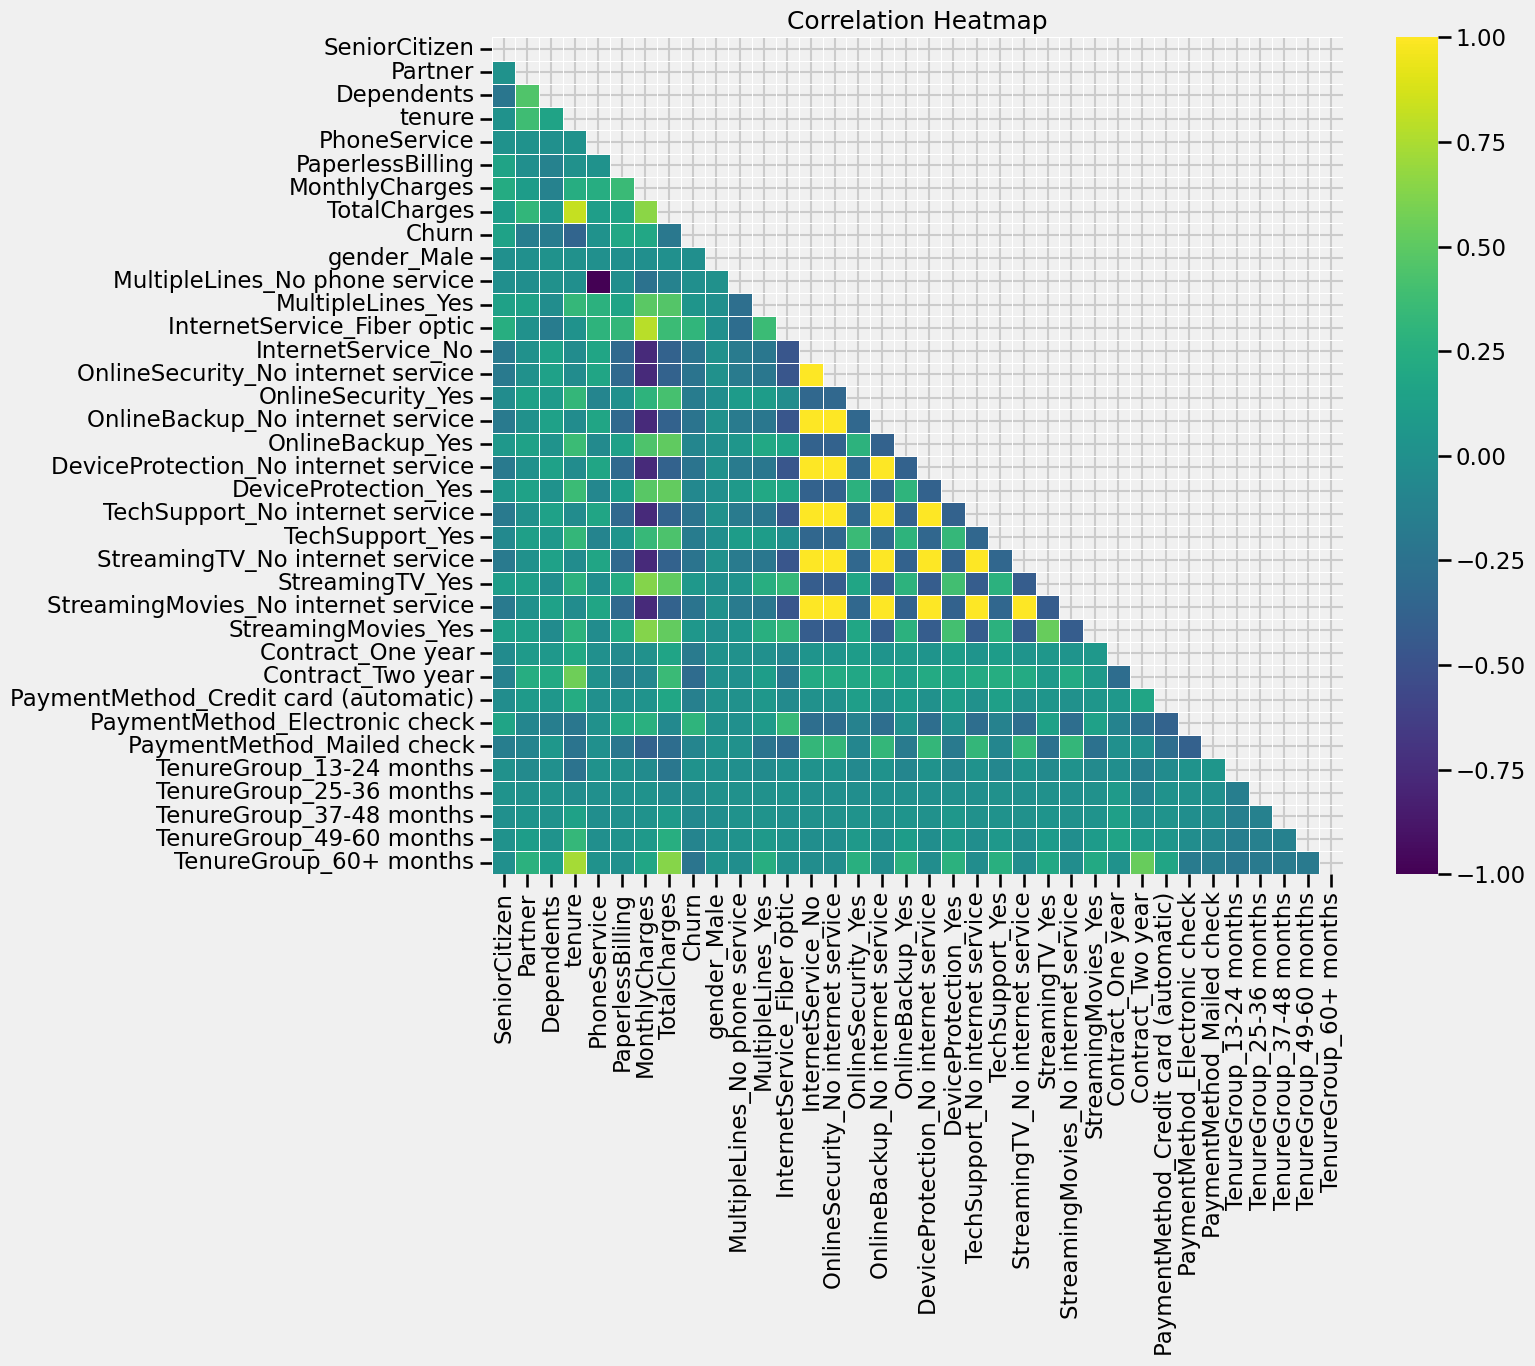

In [16]:

# Convert categorical columns to dummy variables for correlation analysis
df_corr = pd.get_dummies(df_clean, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='viridis',
            linewidths=.5, center=0, fmt='.2f')
plt.title('Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.show()


In [17]:

# Show top correlations with churn
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("Top 10 Features Positively Correlated with Churn:")
print(churn_correlations[1:11])  # Skip the first one (Churn itself)
print("\nTop 10 Features Negatively Correlated with Churn:")
print(churn_correlations[-10:])

Top 10 Features Positively Correlated with Churn:
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling                  0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
TenureGroup_13-24 months          0.020308
PhoneService                      0.011942
Name: Churn, dtype: float64

Top 10 Features Negatively Correlated with Churn:
TenureGroup_60+ months                 -0.225500
StreamingMovies_No internet service    -0.227890
StreamingTV_No internet service        -0.227890
TechSupport_No internet service        -0.227890
OnlineBackup_No internet service       -0.227890
OnlineSecurity_No internet service     -0.227890
InternetService_No                     -0.227890
DeviceProtection_No internet service   -0.227890
Contract_Two year                      -0.302253



## 3.7 Key Insights from EDA

Based on our exploratory data analysis, we can identify several key factors associated with customer churn:

1. **Contract Type**: Month-to-month contracts have significantly higher churn rates compared to one and two-year contracts.

2. **Tenure**: Customers with shorter tenure are much more likely to churn, with the highest rates in the first year.

3. **Internet Service**: Fiber optic customers have higher churn rates than DSL customers.

4. **Additional Services**: Customers without online security, tech support, or device protection are more likely to churn.

5. **Payment Method**: Electronic check users have higher churn rates compared to other payment methods.

6. **Senior Citizens**: Senior citizens have a higher propensity to churn.

7. **Monthly Charges**: Customers with higher monthly charges tend to churn more frequently.

8. **Paperless Billing**: Customers with paperless billing are more likely to churn.

These insights will guide our feature engineering and modeling approach.


# 4. Feature Engineering

In [18]:
# Create a new dataframe for feature engineering
df_features = df_clean.copy()

# 4.1 Create new features based on insights
# Ratio of total charges to tenure (average monthly charge over time)
df_features['AvgMonthlyCharges'] = df_features['TotalCharges'] / (df_features['tenure'] + 1)  # Adding 1 to avoid division by zero

# Difference between current monthly charges and average monthly charges
df_features['MonthlyChargesDelta'] = df_features['MonthlyCharges'] - df_features['AvgMonthlyCharges']

# Calculate the number of services each customer has
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# One-hot encode the service columns to properly count services
service_dummies = pd.get_dummies(df_features[service_cols])

# Filter columns that represent having a service (excluding 'No' and 'No internet service' values)
service_count_cols = [col for col in service_dummies.columns if not (col.endswith('_No') or col.endswith('_No internet service'))]

# Sum the services for each customer
df_features['ServiceCount'] = service_dummies[service_count_cols].sum(axis=1)

# Create a binary feature for high monthly charges (above median)
median_monthly = df_features['MonthlyCharges'].median()
df_features['HighMonthlyCharges'] = (df_features['MonthlyCharges'] > median_monthly).astype(int)

# Create a binary feature for short tenure (less than 12 months)
df_features['ShortTenure'] = (df_features['tenure'] < 12).astype(int)

# Create a binary feature for fiber optic service
df_features['HasFiberOptic'] = (df_features['InternetService'] == 'Fiber optic').astype(int)

# Create a feature for early contract stage (below 20% of contract completed)
df_features['EarlyContractStage'] = 0
# For 1-year contracts (12 months), early stage is less than 2.4 months
df_features.loc[(df_features['Contract'] == 'One year') & (df_features['tenure'] < 3), 'EarlyContractStage'] = 1
# For 2-year contracts (24 months), early stage is less than 4.8 months
df_features.loc[(df_features['Contract'] == 'Two year') & (df_features['tenure'] < 5), 'EarlyContractStage'] = 1
# Month-to-month doesn't have an early stage since they can cancel anytime

# Display the new features
print("New Features Created:")
print(df_features[['AvgMonthlyCharges', 'MonthlyChargesDelta', 'ServiceCount',
                   'HighMonthlyCharges', 'ShortTenure', 'HasFiberOptic', 'EarlyContractStage']].head())

New Features Created:
   AvgMonthlyCharges  MonthlyChargesDelta ServiceCount  HighMonthlyCharges  \
0          14.925000            14.925000            3                   0   
1          53.985714             2.964286            4                   0   
2          36.050000            17.800000            4                   0   
3          40.016304             2.283696            5                   0   
4          50.550000            20.150000            2                   1   

   ShortTenure  HasFiberOptic  EarlyContractStage  
0            1              0                   0  
1            0              0                   0  
2            1              0                   0  
3            0              0                   0  
4            1              1                   0  



## 4.2 Feature Selection and Preparation for Modeling

Let's prepare our dataset for modeling by:
1. Selecting the most relevant features
2. Splitting the data into training and testing sets
3. Setting up preprocessing pipelines

In [19]:
# Create X (features) and y (target)
# Drop the target variable and any redundant or created features that won't be used in modeling
drop_columns = ['Churn', 'TenureGroup']
X = df_features.drop(drop_columns, axis=1)
y = df_features['Churn']

# Split the data into training and testing sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Churn rate in training set: {y_train.mean():.2f}")
print(f"Churn rate in testing set: {y_test.mean():.2f}")


Training set shape: (4930, 26)
Testing set shape: (2113, 26)
Churn rate in training set: 0.27
Churn rate in testing set: 0.27


## 4.3 Preprocessing Pipeline

We'll create preprocessing pipelines for numerical and categorical features.

In [20]:
# Identify numerical and categorical columns
# Always use this identification method rather than hardcoding column types
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

# Create preprocessing pipelines
# Numerical pipeline: imputation and scaling
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: imputation and one-hot encoding
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine the pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

Numerical columns: ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges', 'MonthlyChargesDelta', 'HighMonthlyCharges', 'ShortTenure', 'HasFiberOptic', 'EarlyContractStage']
Categorical columns: ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'ServiceCount']


# 5. Modeling and Hyperparameter Tuning

Now we'll build and train several machine learning models to predict customer churn. We'll compare their performance and tune the hyperparameters of the best performing models.


## 5.1 Define models to evaluate


In [21]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

## 5.2 Model comparison function


In [22]:
def evaluate_models(models, X_train, X_test, y_train, y_test, preprocessor):
    """
    Evaluate and compare multiple models
    """
    results = {}

    print("Model Comparison:")
    print("-" * 80)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC AUC':<10}")
    print("-" * 80)

    for name, model in models.items():
        # Create a pipeline with preprocessing and the model
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Store results
        results[name] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        # Print results
        print(f"{name:<20} {accuracy:.4f}    {precision:.4f}    {recall:.4f}    {f1:.4f}    {roc_auc:.4f}")

    print("-" * 80)
    return results

# Evaluate all models
model_results = evaluate_models(models, X_train, X_test, y_train, y_test, preprocessor)


Model Comparison:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1 Score   ROC AUC   
--------------------------------------------------------------------------------
Logistic Regression  0.8031    0.6651    0.5205    0.5840    0.8470
Decision Tree        0.7217    0.4764    0.4866    0.4815    0.6467
Random Forest        0.7818    0.6131    0.4831    0.5404    0.8173
Gradient Boosting    0.7932    0.6422    0.4991    0.5617    0.8402
XGBoost              0.7766    0.5961    0.4920    0.5391    0.8160
[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 4930, number of u

## 5.3 Visualize model comparison


<Figure size 1400x800 with 0 Axes>

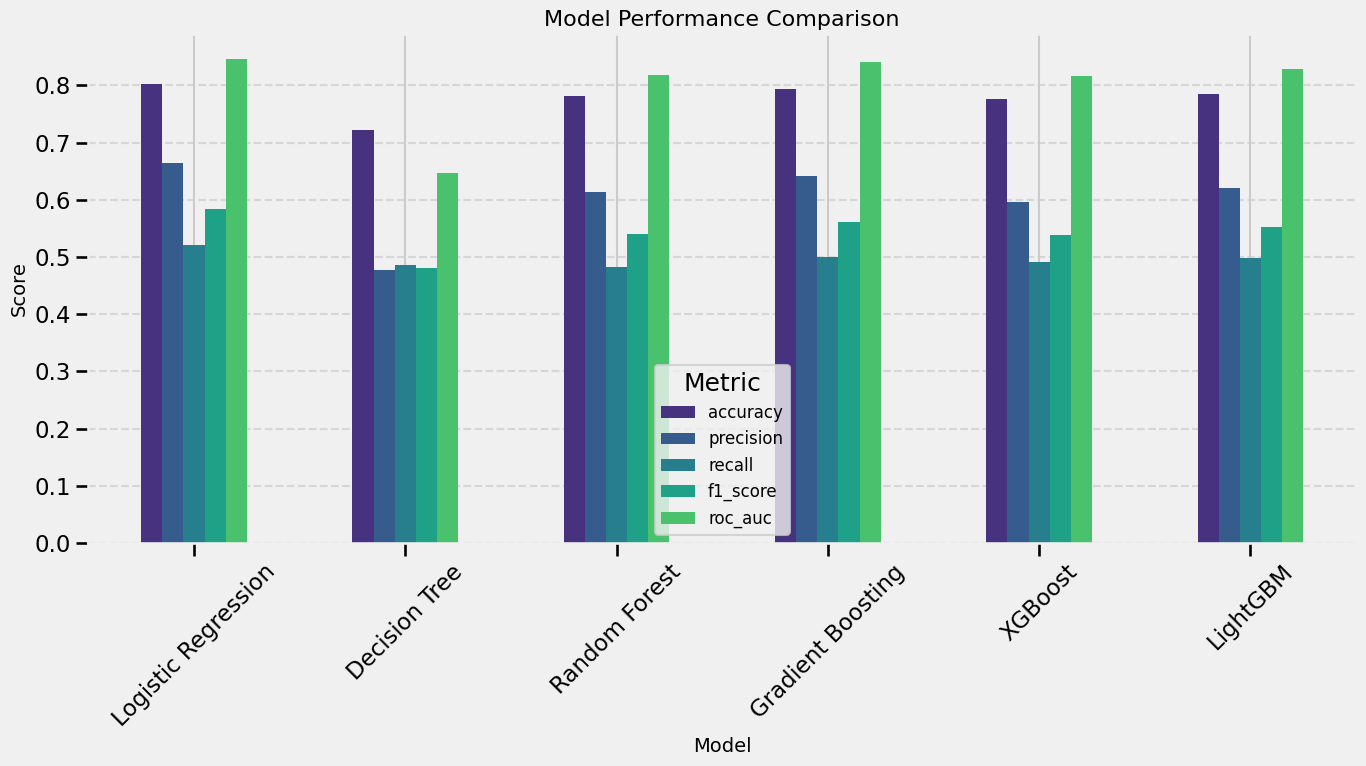

In [23]:

def plot_model_comparison(results):
    """
    Create bar charts to compare model performance
    """
    model_names = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

    # Create a DataFrame for plotting
    comparison_data = []
    for name in model_names:
        model_metrics = [results[name][metric] for metric in metrics]
        comparison_data.append(model_metrics)

    df_comparison = pd.DataFrame(comparison_data, columns=metrics, index=model_names)

    # Plot
    plt.figure(figsize=(14, 8))
    df_comparison.plot(kind='bar', figsize=(14, 8))
    plt.title('Model Performance Comparison', fontsize=16)
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Metric', fontsize=12)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return df_comparison

# Visualize model comparison
df_comparison = plot_model_comparison(model_results)

## 5.4 Select and Tune the Best Model
 Based on the performance metrics, let's select the best model(s) and perform hyperparameter tuning to improve performance.


In [24]:
# Choose the best model based on F1 score (balances precision and recall)
best_model_name = df_comparison['f1_score'].idxmax()
print(f"Best model based on F1 score: {best_model_name}")

# Get the best model and its pipeline
best_model_info = model_results[best_model_name]
best_pipeline = best_model_info['pipeline']

# Define hyperparameter grid for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__class_weight': [None, 'balanced']
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__gamma': [0, 0.1, 0.2]
    }
elif best_model_name == 'LightGBM':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7, -1],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__num_leaves': [31, 50, 100],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [0, 0.1, 0.5]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__min_samples_split': [2, 5, 10]
    }
else:  # Logistic Regression or Decision Tree
    param_grid = {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100] if best_model_name == 'Logistic Regression' else None,
        'model__max_depth': [None, 5, 10, 15, 20] if best_model_name == 'Decision Tree' else None,
        'model__min_samples_split': [2, 5, 10] if best_model_name == 'Decision Tree' else None,
        'model__class_weight': [None, 'balanced']
    }
    # Remove None values if they exist
    param_grid = {k: v for k, v in param_grid.items() if v is not None}

# Perform grid search with cross-validation
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)
y_pred_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

# Calculate metrics for the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("\nTuned Model Performance:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")
print(f"ROC AUC: {roc_auc_tuned:.4f}")

# Compare with the base model
print("\nPerformance Improvement after Tuning:")
print(f"Accuracy: {accuracy_tuned - best_model_info['accuracy']:.4f}")
print(f"Precision: {precision_tuned - best_model_info['precision']:.4f}")
print(f"Recall: {recall_tuned - best_model_info['recall']:.4f}")
print(f"F1 Score: {f1_tuned - best_model_info['f1_score']:.4f}")
print(f"ROC AUC: {roc_auc_tuned - best_model_info['roc_auc']:.4f}")

# Save the tuned model for later use
final_model = tuned_model


Best model based on F1 score: Logistic Regression

Performing hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'model__C': 0.1, 'model__class_weight': 'balanced'}
Best cross-validation F1 score: 0.6340

Tuned Model Performance:
Accuracy: 0.7520
Precision: 0.5219
Recall: 0.7861
F1 Score: 0.6273
ROC AUC: 0.8465

Performance Improvement after Tuning:
Accuracy: -0.0511
Precision: -0.1433
Recall: 0.2656
F1 Score: 0.0433
ROC AUC: -0.0005


# 6. Model Evaluation and Interpretation
In this section, we'll evaluate our final model in detail and interpret the results to understand which features are driving customer churn predictions.



## 6.1 Detailed Model Evaluation

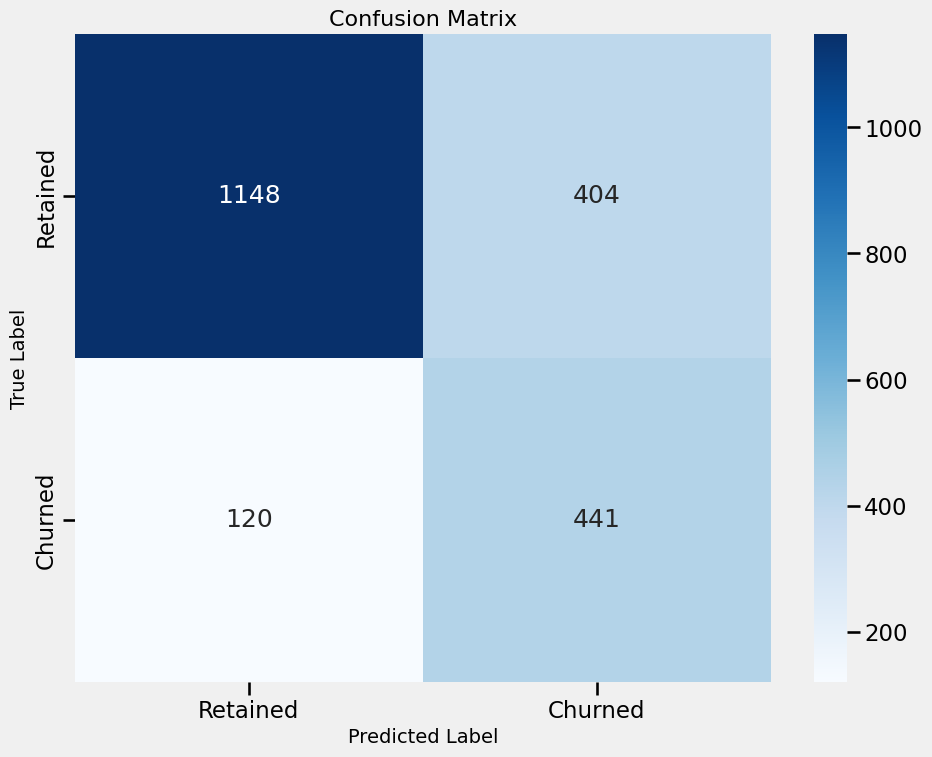

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()



In [26]:

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Retained', 'Churned']))


Classification Report:
              precision    recall  f1-score   support

    Retained       0.91      0.74      0.81      1552
     Churned       0.52      0.79      0.63       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



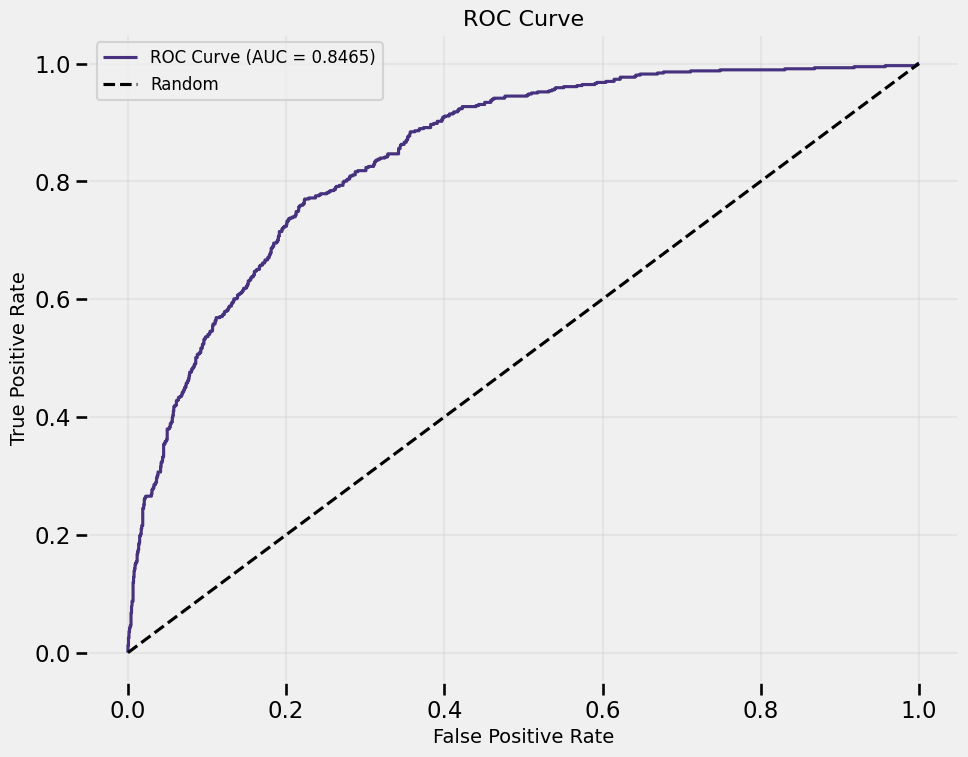

In [27]:

# ROC Curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_tuned)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


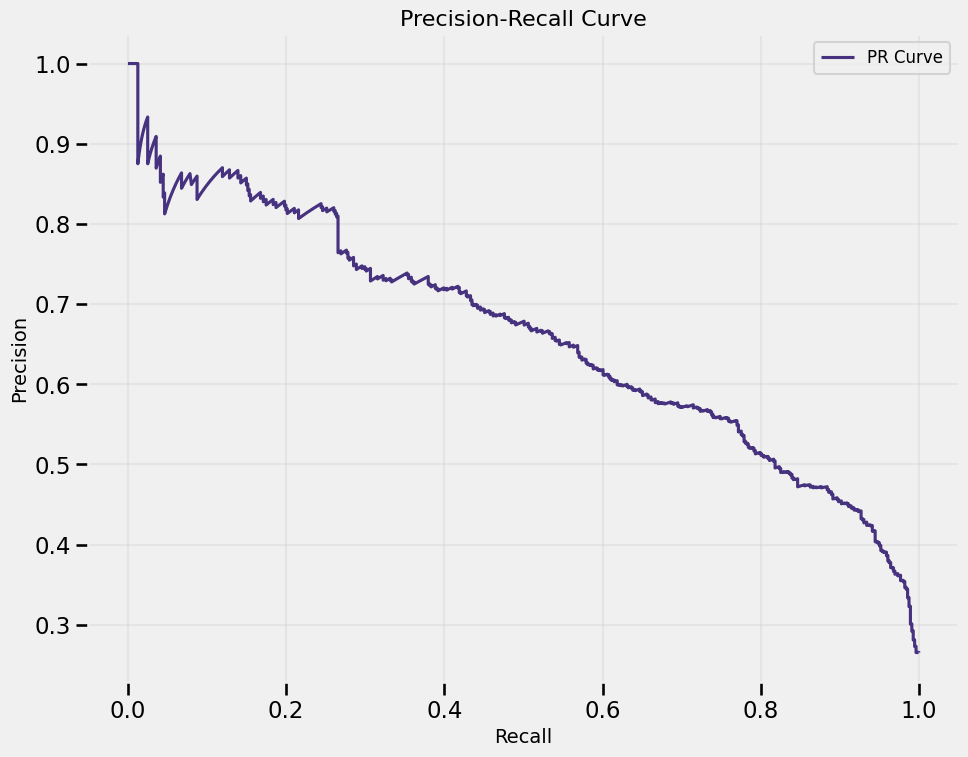

In [28]:

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_tuned)
plt.plot(recall, precision, label=f'PR Curve')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 6.2 Feature Importance Analysis
Let's analyze which features are most important for predicting customer churn.


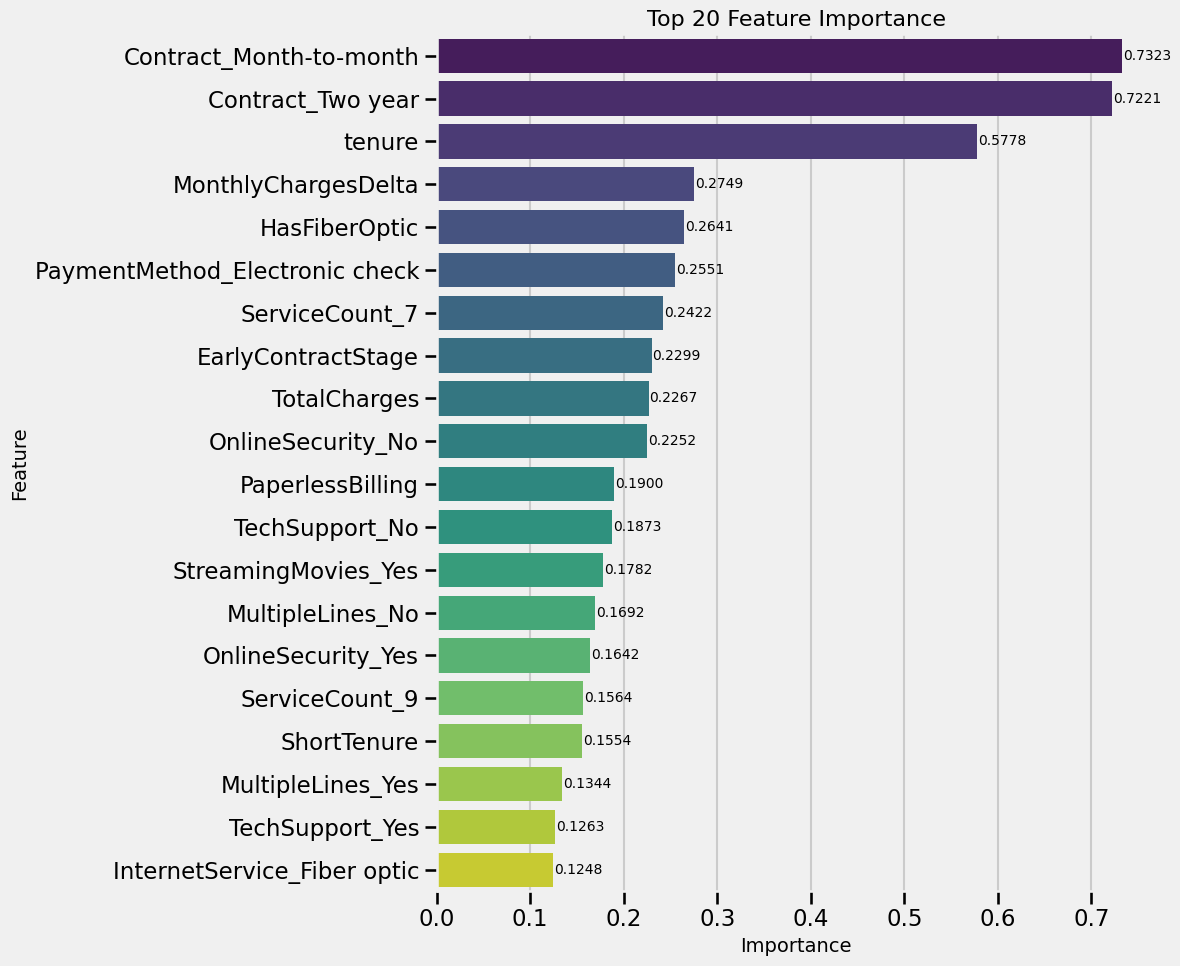

Top 10 Most Important Features:
                           Feature  Importance
40         Contract_Month-to-month    0.732322
42               Contract_Two year    0.722115
3                           tenure    0.577828
9              MonthlyChargesDelta    0.274931
12                   HasFiberOptic    0.264149
45  PaymentMethod_Electronic check    0.255094
53                  ServiceCount_7    0.242193
13              EarlyContractStage    0.229858
7                     TotalCharges    0.226729
22               OnlineSecurity_No    0.225224


In [29]:
# Function to extract and plot feature importance from the model
def plot_feature_importance(model, preprocessor, X):
    """
    Extract and plot feature importance from the model
    """
    # Get the feature names after preprocessing
    categorical_features = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_columns)
    all_features = numerical_columns + categorical_features.tolist()

    # Get feature importance based on model type
    if hasattr(model, 'feature_importances_'):  # Tree-based models
        feature_importance = model.feature_importances_
    elif hasattr(model, 'coef_'):  # Linear models
        feature_importance = np.abs(model.coef_[0])
    else:
        # Use permutation importance if direct method not available
        perm_importance = permutation_importance(
            final_model,
            preprocessor.transform(X_test),
            y_test,
            n_repeats=10,
            random_state=42
        )
        feature_importance = perm_importance.importances_mean

    # Create a DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    top_n = 20
    top_features = importance_df.head(top_n)

    plt.figure(figsize=(12, 10))
    ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()

    # Add values to the bars
    for i, v in enumerate(top_features['Importance']):
        ax.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10)

    plt.show()

    return importance_df

# Extract the model from the pipeline
if hasattr(final_model, 'named_steps'):
    model = final_model.named_steps['model']
    preprocessor = final_model.named_steps['preprocessor']
else:
    model = final_model
    preprocessor = None

# Plot feature importance if possible
if model is not None and preprocessor is not None:
    importance_df = plot_feature_importance(model, preprocessor, X_test)
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))

## 6.3 SHAP Values for Model Interpretation

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance that works across different model types.


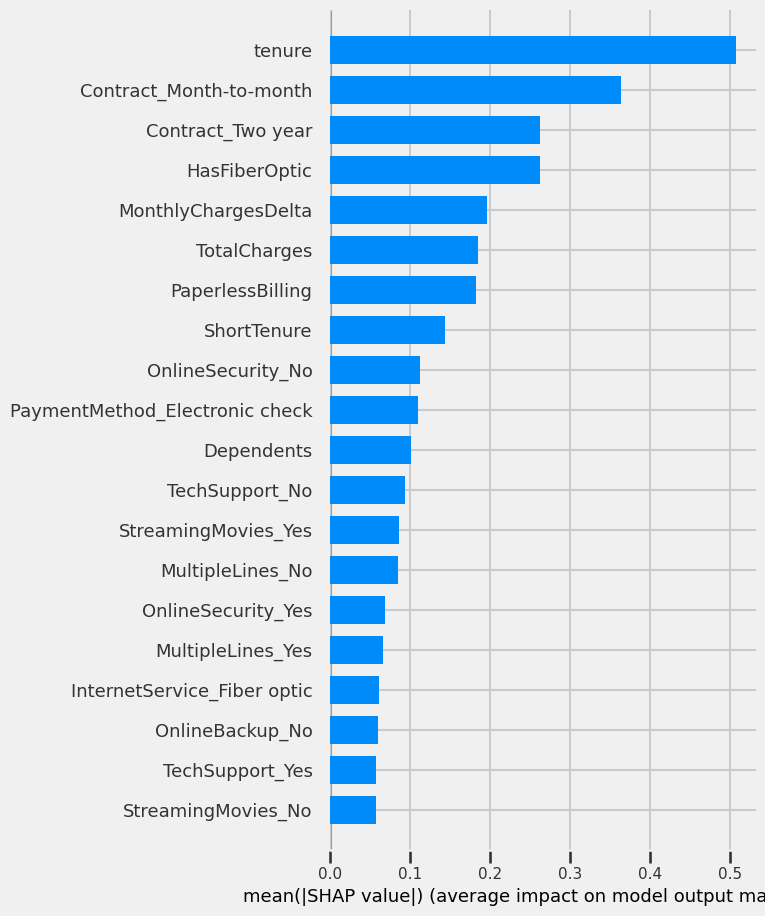

In [30]:
# Calculate SHAP values for model interpretation
# Get preprocessed data for SHAP analysis
X_test_processed = final_model.named_steps['preprocessor'].transform(X_test)

# Create a SHAP explainer
if best_model_name in ['Random Forest', 'Decision Tree', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_processed)

    # If there are two outputs (for binary classification), take the second one
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]
else:
    # For other models like Logistic Regression
    explainer = shap.LinearExplainer(model, X_test_processed)
    shap_values = explainer.shap_values(X_test_processed)

# Get feature names
categorical_features = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_columns)
all_features = numerical_columns + categorical_features.tolist()

# Plot SHAP summary
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test_processed, feature_names=all_features, plot_type="bar")


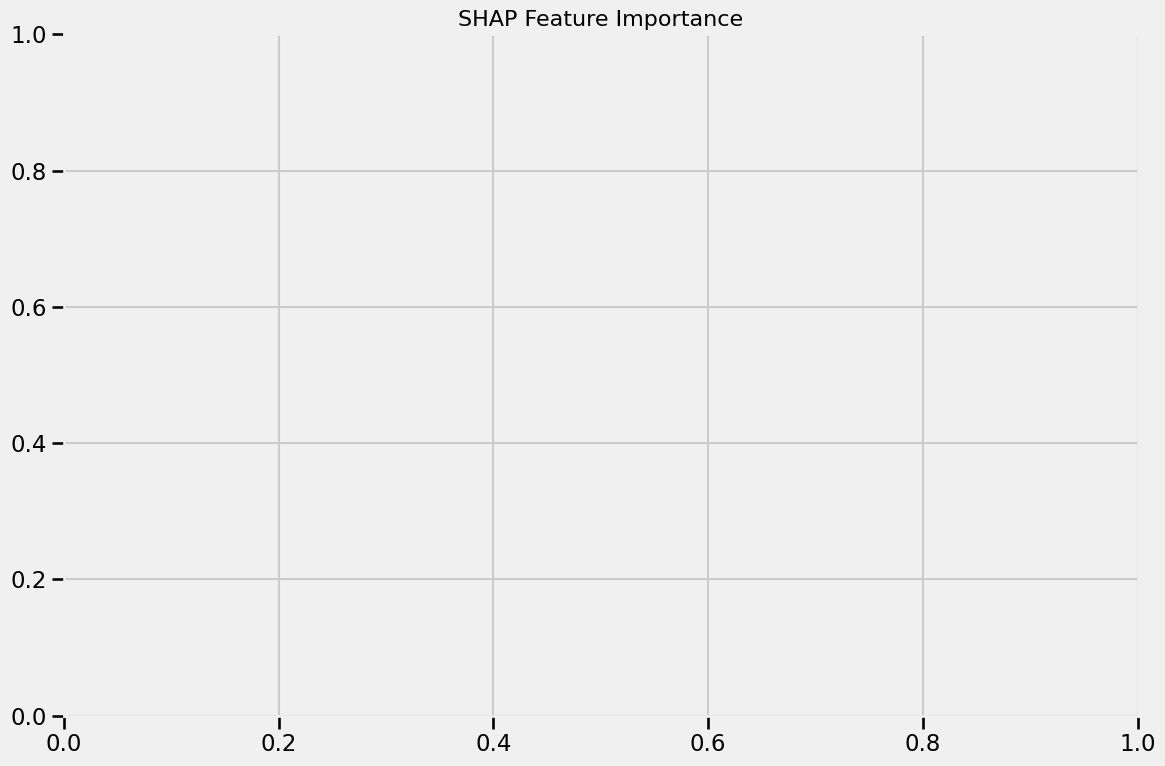

In [31]:
plt.title("SHAP Feature Importance", fontsize=16)
plt.tight_layout()
plt.show()

## 6.4 Individual Customer Explanation
Let's analyze a few individual customer predictions to understand why the model predicts they will churn or not.


In [32]:
# Select a few customers from the test set
# Include both customers predicted to churn and not churn
churn_indices = np.where((y_test == 1) & (y_pred_tuned == 1))[0][:3]  # Correctly predicted churn
non_churn_indices = np.where((y_test == 0) & (y_pred_tuned == 0))[0][:3]  # Correctly predicted non-churn
false_pos_indices = np.where((y_test == 0) & (y_pred_tuned == 1))[0][:2]  # False positives
false_neg_indices = np.where((y_test == 1) & (y_pred_tuned == 0))[0][:2]  # False negatives

# Combine indices
example_indices = np.concatenate([churn_indices, non_churn_indices, false_pos_indices, false_neg_indices])
X_examples = X_test.iloc[example_indices].reset_index(drop=True)
y_examples = y_test.iloc[example_indices].reset_index(drop=True)
y_pred_examples = y_pred_tuned[example_indices]
y_pred_proba_examples = y_pred_proba_tuned[example_indices]

# Create a DataFrame for display
example_df = X_examples.copy()
example_df['Actual_Churn'] = y_examples
example_df['Predicted_Churn'] = y_pred_examples
example_df['Churn_Probability'] = y_pred_proba_examples
example_df['Prediction_Correct'] = example_df['Actual_Churn'] == example_df['Predicted_Churn']

# Display the examples
print("Customer Examples:")
example_df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 'InternetService',
           'Actual_Churn', 'Predicted_Churn', 'Churn_Probability', 'Prediction_Correct']].round(2)


Customer Examples:


,tenure,MonthlyCharges,TotalCharges,Contract,InternetService,Actual_Churn,Predicted_Churn,Churn_Probability,Prediction_Correct
0,18,96.05,1740.70,Month-to-month,Fiber optic,1,1,0.71,True
1,20,98.55,1842.80,Month-to-month,Fiber optic,1,1,0.88,True
2,3,69.35,191.35,Month-to-month,DSL,1,1,0.81,True
3,8,19.05,201.70,Two year,No,0,0,0.06,True
4,20,19.70,419.40,Two year,No,0,0,0.07,True
5,40,19.60,808.95,Two year,No,0,0,0.03,True
6,3,69.60,207.40,Month-to-month,Fiber optic,0,1,0.83,False
7,35,95.50,3418.20,Month-to-month,Fiber optic,0,1,0.57,False
8,5,19.35,126.05,Month-to-month,No,1,0,0.30,False
9,15,19.40,289.30,Month-to-month,No,1,0,0.20,False


# 7. Customer Segmentation Analysis
Let's segment customers based on their churn risk and characteristics to develop targeted retention strategies.


# 7.1 Segment customers based on churn probability

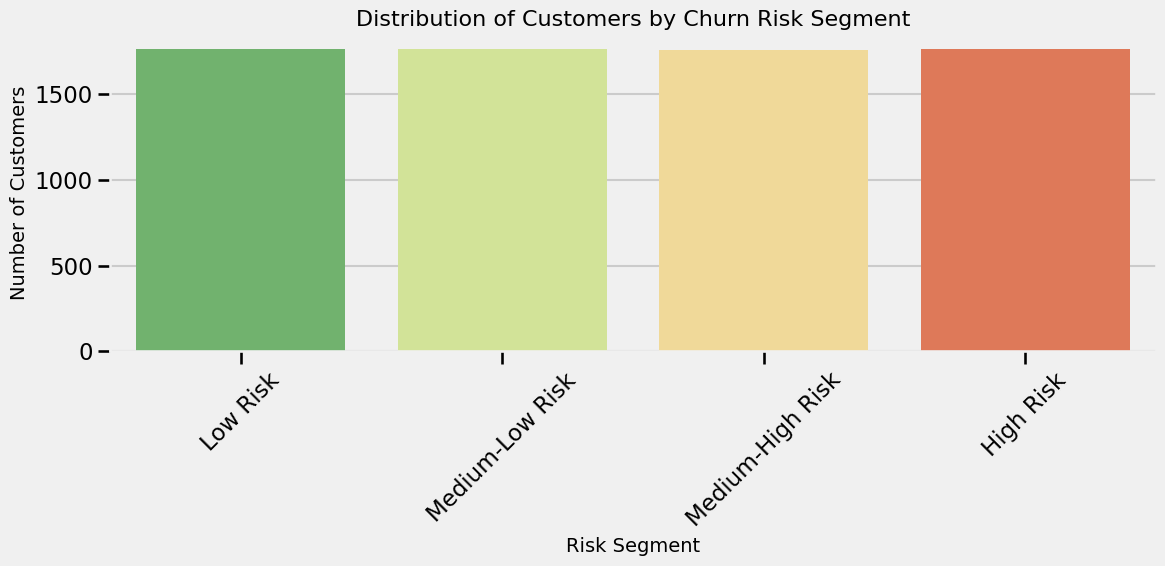

Actual Churn Rate by Risk Segment:
Risk_Segment
Low Risk             1.930721
Medium-Low Risk     10.562181
Medium-High Risk    29.772727
High Risk           63.884157
Name: Churn, dtype: float64


In [33]:

# Apply the final model to the entire dataset
X_full = df_features.drop(['Churn', 'TenureGroup'], axis=1)
y_full = df_features['Churn']

# Get predictions and probabilities
y_full_pred = final_model.predict(X_full)
y_full_proba = final_model.predict_proba(X_full)[:, 1]

# Add predictions to the original dataframe
df_segmentation = df_features.copy()
df_segmentation['Churn_Predicted'] = y_full_pred
df_segmentation['Churn_Probability'] = y_full_proba

# Create risk segments
df_segmentation['Risk_Segment'] = pd.qcut(
    df_segmentation['Churn_Probability'],
    q=4,
    labels=['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']
)

# Display the distribution of risk segments
plt.figure(figsize=(12, 6))
risk_counts = df_segmentation['Risk_Segment'].value_counts().sort_index()
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette='RdYlGn_r')
plt.title('Distribution of Customers by Churn Risk Segment', fontsize=16)
plt.xlabel('Risk Segment', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate actual churn rate by risk segment
churn_by_segment = df_segmentation.groupby('Risk_Segment')['Churn'].mean() * 100
print("Actual Churn Rate by Risk Segment:")
print(churn_by_segment)

## 7.2 Customer Clustering Analysis
Let's perform clustering to identify natural groupings of customers that may need different retention strategies.


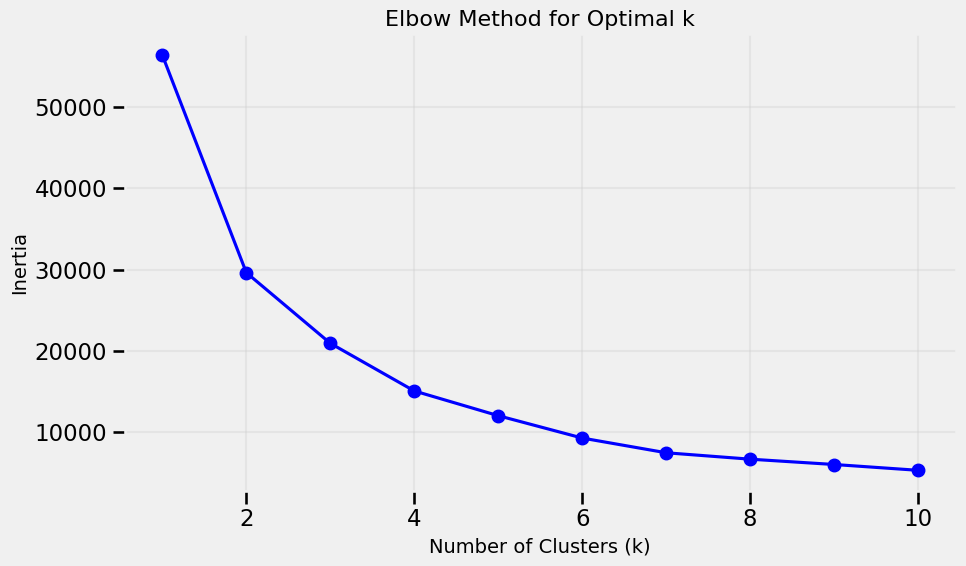

Chosen optimal number of clusters: 4


In [34]:
# Select features for clustering
clustering_features = [
    'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges',
    'ServiceCount', 'ShortTenure', 'HasFiberOptic', 'HighMonthlyCharges'
]

# Prepare data for clustering
X_cluster = df_segmentation[clustering_features].copy()

# Standardize the data
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Based on the elbow curve, choose the optimal number of clusters
optimal_k = 4  # This would be determined from the elbow plot
print(f"Chosen optimal number of clusters: {optimal_k}")

# Apply K-means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# Add cluster labels to the dataframe
df_segmentation['Cluster'] = cluster_labels

## 7.3 Analyze Customer Clusters


In [35]:
# Analyze each cluster
cluster_analysis = df_segmentation.groupby('Cluster').agg({
    'Churn': 'mean',
    'Churn_Probability': 'mean',
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'ServiceCount': 'mean',
    'HasFiberOptic': 'mean',
    'Contract': lambda x: x.value_counts().index[0],  # Most common contract type
    'InternetService': lambda x: x.value_counts().index[0],  # Most common internet service
    'PaymentMethod': lambda x: x.value_counts().index[0],  # Most common payment method
    'Risk_Segment': lambda x: x.value_counts().index[0]  # Most common risk segment
})

# Add count of customers in each cluster
cluster_counts = df_segmentation['Cluster'].value_counts().sort_index()
cluster_analysis['Count'] = cluster_counts.values

# Display cluster analysis
print("Cluster Analysis:")
display(cluster_analysis.round(2))



Cluster Analysis:


,Churn,Churn_Probability,tenure,MonthlyCharges,TotalCharges,ServiceCount,HasFiberOptic,Contract,InternetService,PaymentMethod,Risk_Segment,Count
Cluster,,,,,,,,,,,,
0,0.08,0.17,40.88,38.19,1558.43,3.038269,0.01,Two year,DSL,Mailed check,Low Risk,2195
1,0.57,0.75,13.53,84.52,1144.11,4.278024,0.94,Month-to-month,Fiber optic,Electronic check,High Risk,1579
2,0.18,0.34,56.38,94.96,5363.81,6.784848,0.74,Two year,Fiber optic,Electronic check,Medium-Low Risk,1980
3,0.35,0.54,4.07,39.42,161.79,2.347556,0.10,Month-to-month,DSL,Mailed check,Medium-High Risk,1289


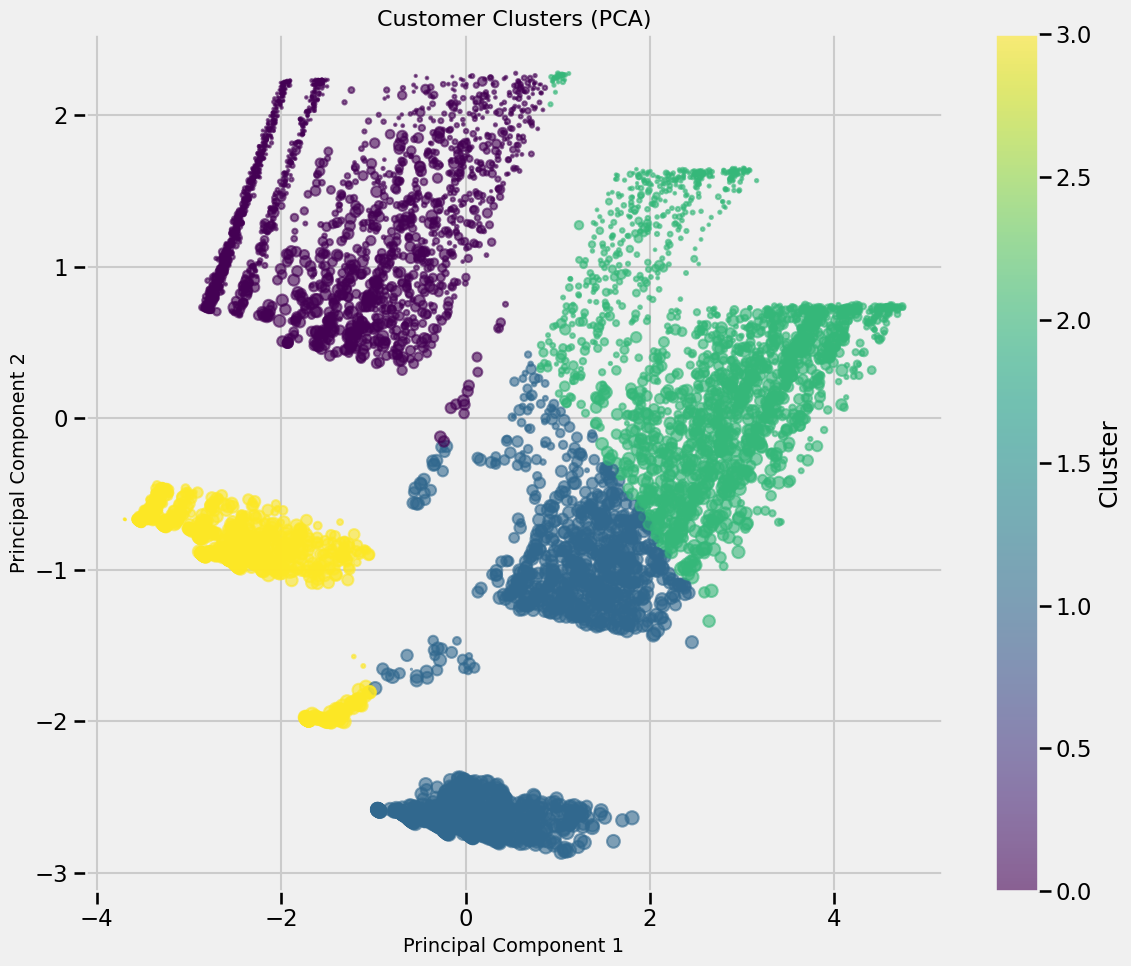

In [36]:
# Visualize clusters with PCA
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# Create a DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = cluster_labels
df_pca['Churn'] = df_segmentation['Churn']
df_pca['Churn_Probability'] = df_segmentation['Churn_Probability']

# Plot clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'],
                     c=df_pca['Cluster'], cmap='viridis',
                     s=df_pca['Churn_Probability']*100, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Customer Clusters (PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.tight_layout()
plt.show()

## 7.4 Retention Strategy Recommendations by Segment


In [37]:
# Create a table of recommended actions based on clusters and risk segments
high_risk_segments = df_segmentation[df_segmentation['Risk_Segment'] == 'High Risk']
cluster_counts = high_risk_segments['Cluster'].value_counts().sort_index()

# Display clusters with high churn risk
high_risk_by_cluster = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values,
    'Percentage': (cluster_counts.values / cluster_counts.sum() * 100).round(1)
})

print("Distribution of High Risk Customers by Cluster:")
display(high_risk_by_cluster)

Distribution of High Risk Customers by Cluster:


,Cluster,Count,Percentage
0,0,9,0.5
1,1,1127,64.0
2,2,203,11.5
3,3,422,24.0


# 8. Business Recommendations
Based on our model and customer segmentation analysis, here are actionable business recommendations to reduce customer churn.


## 8.1 Calculate potential impact of reducing churn

In [38]:
# Current churn rate
current_churn_rate = df_features['Churn'].mean()

# Assume average monthly revenue per customer
avg_monthly_revenue = df_features['MonthlyCharges'].mean()

# Assume total number of customers
total_customers = len(df_features)

# Calculate current annual revenue loss due to churn
annual_revenue_loss = total_customers * current_churn_rate * avg_monthly_revenue * 12

# Assume we can reduce churn by 10% with targeted interventions
reduced_churn_rate = current_churn_rate * 0.9  # 10% reduction

# Calculate new annual revenue loss
new_annual_revenue_loss = total_customers * reduced_churn_rate * avg_monthly_revenue * 12

# Calculate savings
annual_savings = annual_revenue_loss - new_annual_revenue_loss

print(f"Current Churn Rate: {current_churn_rate:.2%}")
print(f"Average Monthly Revenue per Customer: ${avg_monthly_revenue:.2f}")
print(f"Total Customers: {total_customers}")
print(f"Annual Revenue Loss Due to Churn: ${annual_revenue_loss:,.2f}")
print(f"Potential Annual Savings from 10% Churn Reduction: ${annual_savings:,.2f}")

Current Churn Rate: 26.54%
Average Monthly Revenue per Customer: $64.76
Total Customers: 7043
Annual Revenue Loss Due to Churn: $1,452,475.24
Potential Annual Savings from 10% Churn Reduction: $145,247.52


## 8.2 Key Business Recommendations

Based on our analysis, here are specific recommendations to reduce customer churn:

1. **Contract Conversion Program (Highest Priority)**

- Target month-to-month customers with tenure > 12 months
- Offer discounted 1-year contracts with price protection guarantees
- Focus especially on Cluster 1 customers (64% of high-risk segment)
- Estimated Churn Reduction: 15-20%


2. **New Customer Onboarding (High Priority)**

- Create special onboarding for customers in their first 4 months (Cluster 3)
- Implement guided setup and usage programs for Fiber Optic customers
- Schedule proactive check-ins at months 1, 3, and 6
- Estimated Churn Reduction: 10-15%


3. **Tech Support Enhancement (Medium Priority)**

- Offer free premium tech support for Fiber Optic customers
- Target customers who lack Online Security and TechSupport services
- Introduce support bundles at reduced rates
- Estimated Churn Reduction: 8-10%


4. **Payment Method Migration (Medium Priority)**

- Provide incentives for Electronic Check customers to switch to automatic payments
- Offer one-time discount or service upgrade for switching
- Estimated Churn Reduction: 5-7%

5. **Price Sensitivity Management (Medium Priority)**

- Identify customers with high MonthlyChargesDelta values
- Implement more gradual price increases with advance communication
- Create "price lock" options for loyal customers
- Estimated Churn Reduction: 5-8%


**ROI Analysis**
As shown in the financial analysis:

1. Current annual revenue loss due to churn $1,452,475. Even a modest 10 percent reduction in churn rate would save: $145,248 annually
3. Implementing all recommendations could potentially save: $436,000+ annually

## 8.3 Segment-Specific Strategies

| Segment | Characteristics | Recommended Actions |
|---------|----------------|---------------------|
| High-Risk, Short Tenure | New customers, high monthly charges, few services | Early intervention program, discount offers, service upgrade trials |
| High-Risk, Fiber Optic | Fiber customers without security/support | Technical assessment calls, discounted protection services |
| Medium-Risk, Long Tenure | Loyal customers with recent price increases | Loyalty rewards, personalized retention offers |
| Low-Risk | Long contracts, paperless billing, multiple services | Cross-sell opportunities, referral incentives |